# Portfolio risk estimation

In [1]:
from pandas_datareader.data import DataReader
from pandas_datareader.moex import MoexReader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
from finance import plot_adjusted_price, plot_instruments_correlation, plot_mean_avg, correlation_matrix, getData
import datetime
from dateutil.relativedelta import relativedelta
sns.set_style("whitegrid")
%matplotlib inline

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
symbols= ["MSI", "F", "BK", "QQQ"]
start_date = "2000-01-01"
end_date = "2020-10-28"
tickers_data =  getData(symbols, start_date=start_date, end_date=end_date)

MSI
F
BK
QQQ


<AxesSubplot:ylabel='Adjusted closing price ($)'>

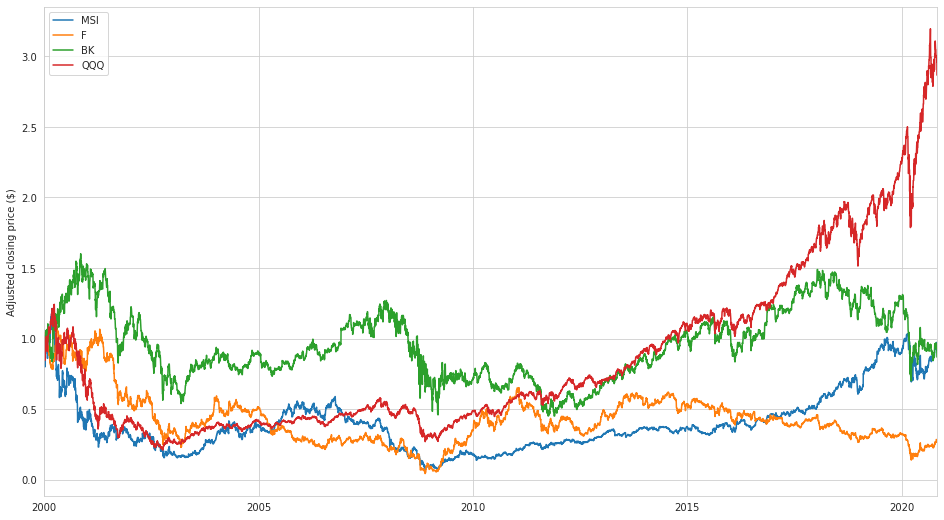

In [3]:
plot_adjusted_price(tickers_data)

In [4]:
def get_accet_returns(tickers_data, delta=relativedelta(months=1)):
    cur_date = tickers_data.index.min() + delta
    max_date = tickers_data.index.max()

    accet_return = pd.DataFrame(columns=tickers_data.columns)
    while cur_date < max_date:
        prev_date = cur_date - delta
        accet_return.loc[cur_date] = (tickers_data.loc[cur_date] - tickers_data.loc[prev_date]) / tickers_data.loc[prev_date]
        cur_date += delta
        
    return accet_return

accet_return = get_accet_returns(tickers_data)

array([[<AxesSubplot:title={'center':'MSI'}>,
        <AxesSubplot:title={'center':'F'}>],
       [<AxesSubplot:title={'center':'BK'}>,
        <AxesSubplot:title={'center':'QQQ'}>]], dtype=object)

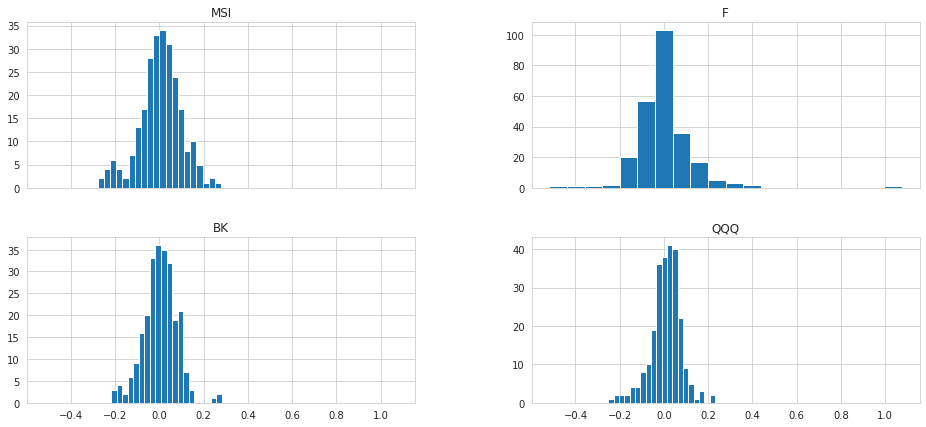

In [5]:
accet_return.hist(bins=20, figsize=(16,7), sharex=True)

In [6]:
avarage_return = accet_return.mean(axis=0)
std_return = accet_return.std(axis=0)
corr_return = accet_return.corr()

In [7]:
print(avarage_return)
print(std_return)
print(corr_return)

MSI    0.004150
F      0.001915
BK     0.002382
QQQ    0.006841
dtype: float64
MSI    0.095621
F      0.130313
BK     0.076486
QQQ    0.069188
dtype: float64
          MSI         F        BK       QQQ
MSI  1.000000  0.362654  0.220368  0.585473
F    0.362654  1.000000  0.317459  0.374144
BK   0.220368  0.317459  1.000000  0.437513
QQQ  0.585473  0.374144  0.437513  1.000000


In [8]:
def portfolio_avarage_return(weights, avarage_return):
    return (weights * avarage_return).sum()

def portfolio_std_return(weights, std_return, corr_return):
    std_return = std_return.values[:, np.newaxis]
    weights = weights.values[:, np.newaxis]
    return (weights.dot(weights.T) * std_return.dot(std_return.T) * corr_return).sum().sum()

In [9]:
from cvxopt import matrix, solvers

In [10]:
P = 2 * matrix(std_return.values * std_return.values[:, np.newaxis] * corr_return.values)
q = matrix(np.zeros_like(std_return.values))
n = len(std_return)
G = matrix(np.zeros(shape=(n,1)), (1, len(std_return)))
h = matrix([[0.0]])
A = matrix([
        [1.0] * len(std_return),
    ], 
    (len(std_return),1)
).trans()
b = matrix([1.0])

sol=solvers.qp(P, q, G, h, A, b, verbose=False)
best_weights = pd.Series(sol["x"], index=std_return.index)
print("\nPortfolio with lowest risk:")
print(best_weights)

     pcost       dcost       gap    pres   dres
 0:  3.6556e-03  3.6556e-03  1e+00  1e+00  9e-19
 1:  3.6556e-03  3.6556e-03  1e-02  1e-02  0e+00
 2:  3.6556e-03  3.6556e-03  1e-04  1e-04  0e+00
 3:  3.6556e-03  3.6556e-03  1e-06  1e-06  0e+00
 4:  3.6556e-03  3.6556e-03  1e-08  1e-08  0e+00
Optimal solution found.

Portfolio with lowest risk:
MSI    0.128780
F      0.016064
BK     0.400956
QQQ    0.454201
dtype: float64


# Same task for pinned return rate

In [ ]:
rs = np.linspace(avarage_return.min()/1.2, avarage_return.max()*1.1, 100)
ws = {}
for r in rs:
    P = 2 * matrix(std_return.values * std_return.values[:, np.newaxis] * corr_return.values)
    q = matrix(np.zeros_like(std_return.values))
    #G = -matrix(1.0 * np.diag([1]*len(corr_return)))
    #h = matrix(q)
    n = len(std_return)
    G = matrix(np.zeros(shape=(n,1)), (1, len(std_return)))
    h = matrix([[0.0]])
    A = matrix([
            [1.0] * len(std_return),
            list(avarage_return.values)
        ], 
        (len(std_return),2)
    ).trans()
    b = matrix([1.0, r])

    sol=solvers.qp(P, q, G, h, A, b, verbose=False)
    weights = pd.Series(sol["x"], index=std_return.index)
    ws[r] = weights
ws = pd.DataFrame(ws).T
print(ws)

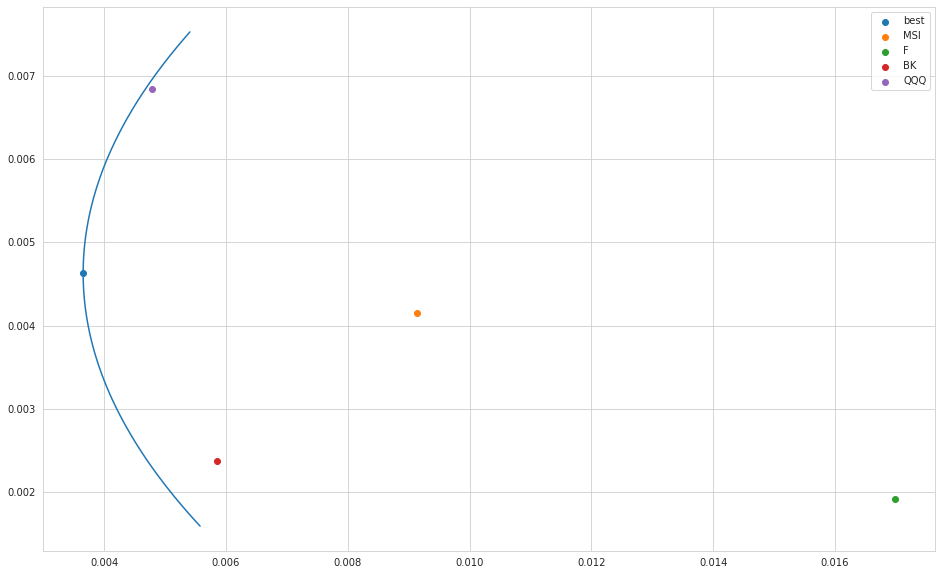

In [12]:
line_x = []
line_y = [] 
for _, weights in ws.iterrows():
    line_x.append(portfolio_std_return(weights, std_return, corr_return))
    line_y.append(portfolio_avarage_return(weights, avarage_return))

fig = plt.figure(figsize=(16,10))
ax = plt.subplot(111)
ax.plot(line_x, line_y)

ax.scatter(
    [portfolio_std_return(best_weights, std_return, corr_return)], 
    [portfolio_avarage_return(best_weights, avarage_return)],
    label="best",
)

for asset_name in ws.columns:
    weights = pd.Series([0]*len(ws.columns), index=ws.columns)
    weights[asset_name] = 1
    ax.scatter(
        [portfolio_std_return(weights, std_return, corr_return)], 
        [portfolio_avarage_return(weights, avarage_return)],
        label=asset_name,
    )
    

ax.legend()

In [13]:
tickers_data["lowest risk"] = (tickers_data * best_weights).sum(axis=1)

<AxesSubplot:ylabel='Adjusted closing price ($)'>

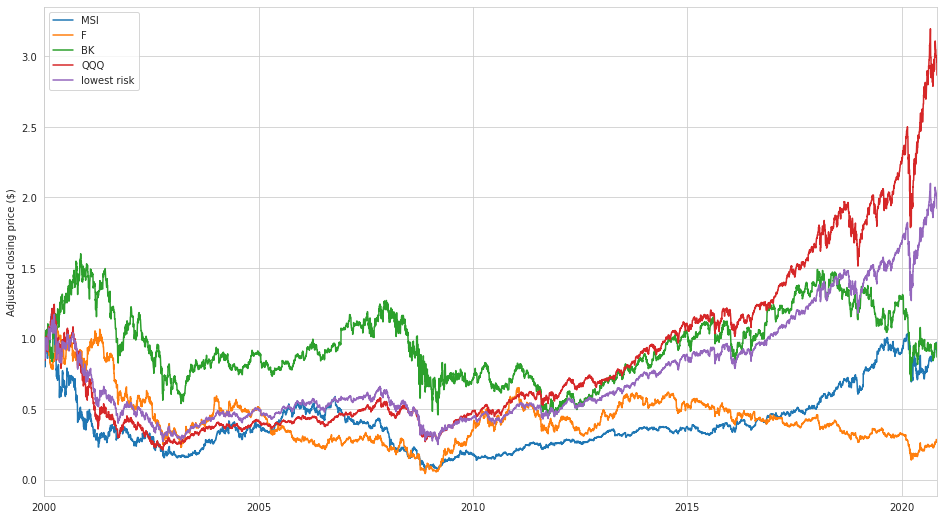

In [14]:
plot_adjusted_price(tickers_data)

array([[<AxesSubplot:title={'center':'MSI'}>,
        <AxesSubplot:title={'center':'F'}>],
       [<AxesSubplot:title={'center':'BK'}>,
        <AxesSubplot:title={'center':'QQQ'}>],
       [<AxesSubplot:title={'center':'lowest risk'}>, <AxesSubplot:>]],
      dtype=object)

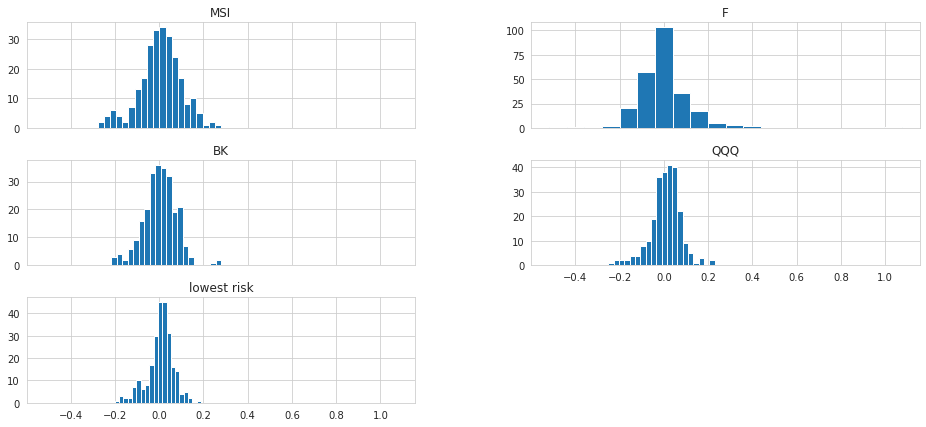

In [15]:
returns = get_accet_returns(tickers_data)
returns.hist(bins=20, figsize=(16,7), sharex=True)